# Data Preperation


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib import request
from tqdm import tqdm
import gzip
import os

# --- Tải dữ liệu Fashion MNIST ---
folder = 'data_fashion_mnist/'
os.makedirs(folder, exist_ok=True)

filenames = ["train-images-idx3-ubyte.gz",
             "train-labels-idx1-ubyte.gz",
             "t10k-images-idx3-ubyte.gz",
             "t10k-labels-idx1-ubyte.gz"]

base_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"
for name in filenames:
    if not os.path.exists(folder + name):
        print(f"Downloading {name}...")
        request.urlretrieve(base_url + name, folder + name)
    else:
        print(f"{name} already downloaded.")

# --- Đọc dữ liệu đã tải ---
with gzip.open('data_fashion_mnist/train-images-idx3-ubyte.gz', 'rb') as f:
    X = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28 * 28)
with gzip.open('data_fashion_mnist/t10k-images-idx3-ubyte.gz', 'rb') as f:
    X_test = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28 * 28)
with gzip.open('data_fashion_mnist/train-labels-idx1-ubyte.gz', 'rb') as f:
    Y = np.frombuffer(f.read(), np.uint8, offset=8)
with gzip.open('data_fashion_mnist/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    Y_test = np.frombuffer(f.read(), np.uint8, offset=8)

train-images-idx3-ubyte.gz already downloaded.
train-labels-idx1-ubyte.gz already downloaded.
t10k-images-idx3-ubyte.gz already downloaded.
t10k-labels-idx1-ubyte.gz already downloaded.


# Norm + One hot encoding

In [ ]:
# --- (Norm) ---

def Normalize_guassian(data):
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis=0)
    return (data - mean) / (std + 1e-8)

X = Normalize_guassian(X)
X_test = Normalize_guassian(X_test)

# --- One-hot encoding ---
Y = np.array(pd.get_dummies(Y))
Y_test = np.array(pd.get_dummies(Y_test))

# Activation Function & Đạo hàm


In [ ]:
# --- Hàm kích hoạt (Activation functions) ---
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

def leaky_relu(Z):
    return np.where(Z > 0, Z, Z * 0.01)

def leaky_relu_back(dl, Z, alpha=0.01):
    dx = np.ones_like(Z)
    dx[Z < 0] = alpha
    return dx * dl

def sigmoid_back(dA, Z):
    return dA * sigmoid(Z) * (1 - sigmoid(Z))

def relu_back(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

def softmax(u):
    u_exp = np.exp(u - np.max(u, axis=1, keepdims=True))
    return u_exp / np.sum(u_exp, axis=-1, keepdims=True)

# Helper layer fun
## 1. Tạo ma trận trọng số theo layers
Dis: Sẽ tạo ra các ma trận trọng số tương ứng với các layers trong layer_dim, kèm theo luôn cả trọng số b

+ He Initialize để tránh lỗi

In [ ]:
# Định nghĩa cấu trúc layer_dim: [số nơ-ron đầu vào, số nơ-ron đầu ra]
# E.g: layer_dim = [[784, 256], [256, 256], [256,128],[128,64], [64, 10]]
def init_weight_bias(layer_dim):
    W = []
    for i in layer_dim:
        weight = np.random.randn(i[0] + 1, i[1]) * np.sqrt(2 / i[1])
        # He Ini
        # i[0] + 1 ,i[1] số input node + 1 (bias), output node
        W.append(weight)
    return W



## 2. Tách batch train

In [ ]:
# --- = DataLoader nếu dùng thư viện ---
def next_batch(X, Y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        yield X[i:i + batch_size], Y[i:i + batch_size]

## 2.Forward pass


In [ ]:
class Forward_layers:
    def __init__(self, layer):
        self.W = layer["weights"]
        self.activation = layer["activations"]
        self.layer_dim = layer["layer_dim"]
        self.num_layer = len(self.layer_dim)

    def fit(self, A_prev, W, activation):
        A_prev_bias = np.hstack((A_prev, np.ones((A_prev.shape[0], 1))))
        Z_curr = np.dot(A_prev_bias, W)

        if activation == "relu":
            return relu(Z_curr), Z_curr
        elif activation == "sigmoid":
            return sigmoid(Z_curr), Z_curr
        elif activation == "leaky_relu":
            return leaky_relu(Z_curr), Z_curr
        elif activation == "softmax":
            return softmax(Z_curr), Z_curr
        raise ValueError("Invalid act. func")

    def forward(self, X):
        memory_A, memory_Z = [], []
        A_curr = X
        for i in range(self.num_layer):
            A_prev = A_curr
            A_curr, Z_curr = self.fit(A_prev, self.W[i], self.activation[i])
            memory_A.append(A_prev)
            memory_Z.append(Z_curr)
        return A_curr, Z_curr, memory_A, memory_Z

## 3.Backward pass

In [ ]:
class Backward_layers:
    def __init__(self, layer):
        self.activation = layer["activations"]
        self.layer_dim = layer["layer_dim"]
        self.num_layer = len(self.layer_dim)

    def fit(self, dA_curr, W_curr, Z_curr, A_prev, activation_back):
        N = A_prev.shape[0]

        A_prev_bias = np.hstack((A_prev, np.ones((N, 1))))

        if activation_back == "relu":
            dZ_curr = relu_back(dA_curr, Z_curr)
        elif activation_back == "sigmoid":
            dZ_curr = sigmoid_back(dA_curr, Z_curr)
        elif activation_back == "leaky_relu":
            dZ_curr = leaky_relu_back(dA_curr, Z_curr)
        else:
            dZ_curr = dA_curr


        dW_curr = np.dot(A_prev_bias.T, dZ_curr) / N

        # Cột cuối cùng của dA_prev_with_bias là gradient đối với bias, không cần truyền ngược, Nên chúng ta chỉ lấy các cột đầu tiên (tương ứng với các feature)
        dA_prev = np.dot(dZ_curr, W_curr[:-1, :].T)

        return dA_prev, dW_curr

    def backward(self, Y_h, Y, memory_W, memory_A, memory_Z):
        dA_prev = Y_h - Y
        gradient_W = []
        for i in range(self.num_layer):
            dA_curr = dA_prev
            W_curr = memory_W[-i - 1]
            Z_curr = memory_Z[-i - 1]
            A_prev = memory_A[-i - 1]

            dA_prev, dW_curr = self.fit(dA_curr, W_curr, Z_curr, A_prev, self.activation[-i - 1])
            gradient_W.append(dW_curr)

        return gradient_W

## 4. Tự build 1 class Sequential
1 class kế thừa từ 2 class trên và tạo ra 1 model có thể chạy forward lẫn backward, và cung cấp những hàm cần thiết để  tính loss, accuracy

In [ ]:
class ANN(Forward_layers, Backward_layers):
    def __init__(self, layer, clip_gradient_value=None):
        super().__init__(layer)
        self.layer = layer
        self.clip_gradient_value = clip_gradient_value

    def fit(self, X, Y):
        forward = Forward_layers(self.layer)
        A_curr, Z_curr, memory_A, memory_Z = forward.forward(X)

        Y_h = A_curr
        backward = Backward_layers(self.layer)
        gradient_W = backward.backward(Y_h, Y, self.layer["weights"], memory_A, memory_Z)

        for i in range(len(self.layer_dim)):
            self.layer["weights"][-i - 1] -= lr * gradient_W[i]
            # Không còn cập nhật bias riêng

    def forward(self, X):
        forward = Forward_layers(self.layer)
        A_curr, _, _, _ = forward.forward(X)
        return A_curr

    def predict(self, X):
        Y_h_prob = self.forward(X)
        return np.where(softmax(Y_h_prob) >= np.max(softmax(Y_h_prob), axis=1, keepdims=True), 1, 0)

    def predict_prob(self, X):
        return self.forward(X)

    def score(self, X, Y):
        Y_h_prob = self.forward(X)
        Y_h_class = np.where(softmax(Y_h_prob) >= np.max(softmax(Y_h_prob), axis=1, keepdims=True), 1, 0)
        return np.mean([np.array_equal(Y_h_class[i], Y[i]) for i in range(len(Y))]) * 100 # Accuracy thang 100

    def cost(self, X, Y):
        Y_h_prob = self.forward(X)
        return -np.mean(np.sum(Y * np.log(softmax(Y_h_prob) + 1e-10), axis=1))

# Train

In [ ]:
# --- Setup ---
batch_size = 256
epochs = 400
lr = 0.01
layer_dim = [[784, 256], [256, 10]]
memory_W = init_weight_bias(layer_dim)
layer = {"layer_dim": layer_dim, "activations": [ "relu","softmax"], "weights": memory_W}


# Training loop ---
model = ANN(layer)
losses_train, losses_test, accuracies_train, accuracies_test = [], [], [], []
for epoch in range(epochs):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X_train = X[indices]
    y_train = Y[indices]
    loss_train, acc_train = [], []
    for batch_X, batch_Y in next_batch(X_train, y_train, batch_size):
        model.fit(batch_X, batch_Y)
        loss_train.append(model.cost(batch_X, batch_Y))
        acc_train.append(model.score(batch_X, batch_Y))
    losses_train.append(np.mean(loss_train))
    accuracies_train.append(np.mean(acc_train))
    losses_test.append(model.cost(X_test, Y_test))
    accuracies_test.append(model.score(X_test, Y_test))

    print(f"Epoch {epoch+1}, Train Loss: {np.mean(loss_train):.4f}, Train Acc: {np.mean(acc_train):.2f}%", f"Test Loss: {losses_test[-1]:.4f}, Test Acc: {accuracies_test[-1]:.2f}%")


Epoch 1, Train Loss: 1.7032, Train Acc: 76.28% Test Loss: 1.6912, Test Acc: 77.04%
Epoch 2, Train Loss: 1.6327, Train Acc: 83.67% Test Loss: 1.6677, Test Acc: 79.69%
Epoch 3, Train Loss: 1.6152, Train Acc: 85.60% Test Loss: 1.6593, Test Acc: 80.73%
Epoch 4, Train Loss: 1.6049, Train Acc: 86.83% Test Loss: 1.6524, Test Acc: 81.59%
Epoch 5, Train Loss: 1.5973, Train Acc: 87.74% Test Loss: 1.6454, Test Acc: 82.20%
Epoch 6, Train Loss: 1.5914, Train Acc: 88.37% Test Loss: 1.6481, Test Acc: 81.84%
Epoch 7, Train Loss: 1.5862, Train Acc: 89.07% Test Loss: 1.6366, Test Acc: 83.00%
Epoch 8, Train Loss: 1.5817, Train Acc: 89.51% Test Loss: 1.6409, Test Acc: 82.79%
Epoch 9, Train Loss: 1.5777, Train Acc: 90.06% Test Loss: 1.6323, Test Acc: 83.58%
Epoch 10, Train Loss: 1.5740, Train Acc: 90.49% Test Loss: 1.6320, Test Acc: 83.57%
Epoch 11, Train Loss: 1.5711, Train Acc: 90.88% Test Loss: 1.6380, Test Acc: 83.01%
Epoch 12, Train Loss: 1.5685, Train Acc: 91.18% Test Loss: 1.6294, Test Acc: 84.03%
E

# Plotting


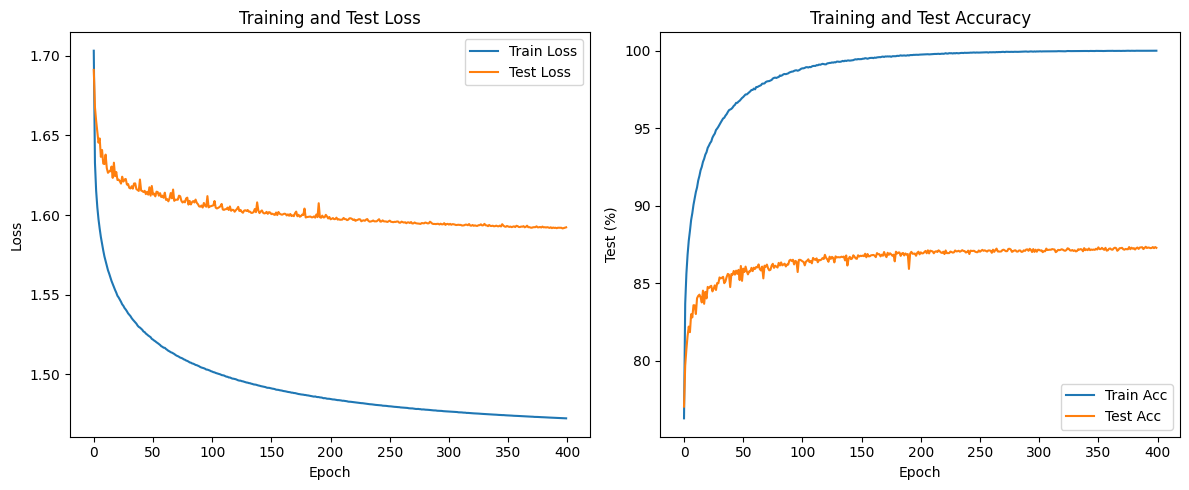

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_train, label="Train Loss")
plt.plot(losses_test, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Test Loss")

plt.subplot(1, 2, 2)
plt.plot(accuracies_train, label="Train Acc")
plt.plot(accuracies_test, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Test (%)")
plt.legend()
plt.title("Training and Test Accuracy")
plt.tight_layout()
plt.show()

In [ ]:
# --- Setup ---
batch_size = 256
epochs = 400
lr = 0.01
layer_dim = [[784, 512],[512,256],[256,128],[128, 10]]
memory_W = init_weight_bias(layer_dim)
layer = {"layer_dim": layer_dim, "activations": ["relu","relu","relu","softmax"], "weights": memory_W}


# Training loop ---
model = ANN(layer)
losses_train, losses_test, accuracies_train, accuracies_test = [], [], [], []
for epoch in range(epochs):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X_train = X[indices]
    y_train = Y[indices]
    loss_train, acc_train = [], []
    for batch_X, batch_Y in next_batch(X_train, y_train, batch_size):
        model.fit(batch_X, batch_Y)
        loss_train.append(model.cost(batch_X, batch_Y))
        acc_train.append(model.score(batch_X, batch_Y))
    losses_train.append(np.mean(loss_train))
    accuracies_train.append(np.mean(acc_train))
    losses_test.append(model.cost(X_test, Y_test))
    accuracies_test.append(model.score(X_test, Y_test))

    print(f"Epoch {epoch+1}, Train Loss: {np.mean(loss_train):.4f}, Train Acc: {np.mean(acc_train):.2f}%", f"Test Loss: {losses_test[-1]:.4f}, Test Acc: {accuracies_test[-1]:.2f}%")


Epoch 1, Train Loss: 1.6633, Train Acc: 82.36% Test Loss: 1.6852, Test Acc: 79.20%
Epoch 2, Train Loss: 1.6195, Train Acc: 87.70% Test Loss: 1.6667, Test Acc: 81.77%
Epoch 3, Train Loss: 1.6039, Train Acc: 89.57% Test Loss: 1.6602, Test Acc: 82.50%
Epoch 4, Train Loss: 1.5935, Train Acc: 90.70% Test Loss: 1.6493, Test Acc: 83.30%
Epoch 5, Train Loss: 1.5847, Train Acc: 91.62% Test Loss: 1.6485, Test Acc: 83.34%
Epoch 6, Train Loss: 1.5781, Train Acc: 92.29% Test Loss: 1.6408, Test Acc: 83.99%
Epoch 7, Train Loss: 1.5719, Train Acc: 93.04% Test Loss: 1.6370, Test Acc: 84.40%
Epoch 8, Train Loss: 1.5666, Train Acc: 93.63% Test Loss: 1.6349, Test Acc: 84.37%
Epoch 9, Train Loss: 1.5618, Train Acc: 94.13% Test Loss: 1.6327, Test Acc: 84.62%
Epoch 10, Train Loss: 1.5572, Train Acc: 94.59% Test Loss: 1.6344, Test Acc: 84.63%
Epoch 11, Train Loss: 1.5536, Train Acc: 94.98% Test Loss: 1.6295, Test Acc: 84.89%
Epoch 12, Train Loss: 1.5502, Train Acc: 95.32% Test Loss: 1.6302, Test Acc: 84.94%
E

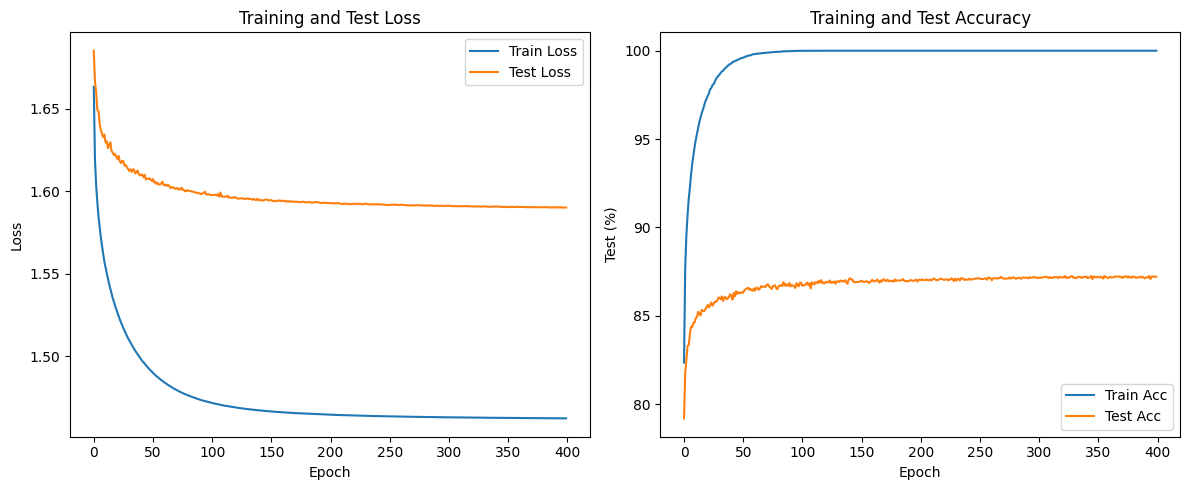

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_train, label="Train Loss")
plt.plot(losses_test, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Test Loss")

plt.subplot(1, 2, 2)
plt.plot(accuracies_train, label="Train Acc")
plt.plot(accuracies_test, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Test (%)")
plt.legend()
plt.title("Training and Test Accuracy")
plt.tight_layout()
plt.show()

In [ ]:
# --- Setup ---
batch_size = 256
epochs = 400
lr = 0.01
layer_dim = [[784, 1024],[1024,512],[512,128],[128, 10]]
memory_W = init_weight_bias(layer_dim)
layer = {"layer_dim": layer_dim, "activations": ["relu","relu","relu","softmax"], "weights": memory_W}


# Training loop ---
model = ANN(layer)
losses_train, losses_test, accuracies_train, accuracies_test = [], [], [], []
for epoch in range(epochs):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X_train = X[indices]
    y_train = Y[indices]
    loss_train, acc_train = [], []
    for batch_X, batch_Y in next_batch(X_train, y_train, batch_size):
        model.fit(batch_X, batch_Y)
        loss_train.append(model.cost(batch_X, batch_Y))
        acc_train.append(model.score(batch_X, batch_Y))
    losses_train.append(np.mean(loss_train))
    accuracies_train.append(np.mean(acc_train))
    losses_test.append(model.cost(X_test, Y_test))
    accuracies_test.append(model.score(X_test, Y_test))

    print(f"Epoch {epoch+1}, Train Loss: {np.mean(loss_train):.4f}, Train Acc: {np.mean(acc_train):.2f}%", f"Test Loss: {losses_test[-1]:.4f}, Test Acc: {accuracies_test[-1]:.2f}%")


Epoch 1, Train Loss: 1.6346, Train Acc: 85.61% Test Loss: 1.6638, Test Acc: 81.89%
Epoch 2, Train Loss: 1.5941, Train Acc: 90.64% Test Loss: 1.6465, Test Acc: 83.23%
Epoch 3, Train Loss: 1.5773, Train Acc: 92.59% Test Loss: 1.6360, Test Acc: 84.46%
Epoch 4, Train Loss: 1.5656, Train Acc: 93.85% Test Loss: 1.6322, Test Acc: 85.04%
Epoch 5, Train Loss: 1.5564, Train Acc: 94.82% Test Loss: 1.6269, Test Acc: 85.42%
Epoch 6, Train Loss: 1.5496, Train Acc: 95.50% Test Loss: 1.6224, Test Acc: 85.66%
Epoch 7, Train Loss: 1.5428, Train Acc: 96.12% Test Loss: 1.6225, Test Acc: 85.44%
Epoch 8, Train Loss: 1.5373, Train Acc: 96.59% Test Loss: 1.6234, Test Acc: 85.52%
Epoch 9, Train Loss: 1.5326, Train Acc: 97.04% Test Loss: 1.6191, Test Acc: 86.01%
Epoch 10, Train Loss: 1.5284, Train Acc: 97.39% Test Loss: 1.6173, Test Acc: 86.06%
Epoch 11, Train Loss: 1.5243, Train Acc: 97.71% Test Loss: 1.6127, Test Acc: 86.61%
Epoch 12, Train Loss: 1.5207, Train Acc: 98.00% Test Loss: 1.6116, Test Acc: 86.75%
E